# SWMAL Exercise

## Pipelines

We now try building af ML pipeline. The data for this exercise is the same as in L01, meaning that the OECD data from the 'intro.ipynb' have been save into a Python 'pickle' file. 

The pickle library is a nifty data preservation method in Python, and from L01 the tuple `(X, y)` have been stored to the pickle file `itmal_l01_data.pkl', try reloading it..

In [2]:
%matplotlib inline

import sys
import pickle
import numpy as np
import matplotlib.pyplot as plt

from sklearn.neural_network import MLPRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

def LoadDataFromL01():
    filename = "Data/itmal_l01_data.pkl"
    with open(f"{filename}", "rb") as f:
        (X, y) = pickle.load(f)
        return X, y

X, y = LoadDataFromL01()

print(f"X.shape={X.shape},  y.shape={y.shape}")

assert X.shape[0] == y.shape[0]
assert X.ndim == 2
assert y.ndim == 1  # did a y.ravel() before saving to picke file
assert X.shape[0] == 29

# re-create plot data (not stored in the Pickel file)
m = np.linspace(0, 60000, 1000)
M = np.empty([m.shape[0], 1])
M[:, 0] = m

print("OK")

X.shape=(29, 1),  y.shape=(29,)
OK


###  Revisiting the problem with the MLP

Using the MLP for the QECD data in Qd) from `intro.ipynb` produced a negative $R^2$, meaning that it was unable to fit the data, and the MPL model was actually _worse_ than the naive $\hat y$ (mean value of y).

Let's just revisit this fact. When running the next cell you should now see an OK $~R^2_{lin.reg}~$ score and a negative $~R^2_{mlp}~$ score..

The MLP may mis-fit the data, seen in the, sometimes, bad R^2 score..



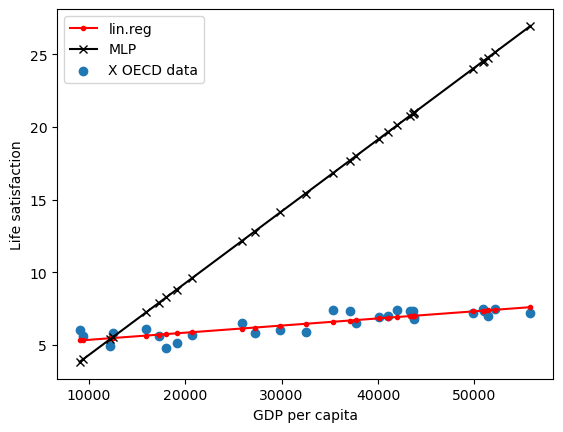

lin.reg.score(X, y)=0.73
    MLP.score(X, y)=-188.94

OK


In [3]:
# Setup the MLP and lin. regression again..

def isNumpyData(t: np.ndarray, expected_ndim: int):
    assert isinstance(expected_ndim, int), f"input parameter 'expected_ndim' is not an integer but a '{type(expected_ndim)}'"
    assert expected_ndim>=0, f"expected input parameter 'expected_ndim' to be >=0, got {expected_ndim}"
    if t is None:
        print("input parameter 't' is None", file=sys.stderr)
        return False
    if not isinstance(t, np.ndarray):
        print("excepted numpy.ndarray got type '{type(t)}'", file=sys.stderr)
        return False
    if not t.ndim==expected_ndim:
        print("expected ndim={expected_ndim} but found {t.ndim}", file=sys.stderr)
        return False
    return True

def PlotModels(model1, model2, X: np.ndarray, y: np.ndarray, name_model1: str, name_model2: str):
    
    # NOTE: local function is such a nifty feature of Python!
    def CalcPredAndScore(model, X: np.ndarray, y: np.ndarray,):
        assert isNumpyData(X, 2) and isNumpyData(y, 1) and X.shape[0]==y.shape[0]
        y_pred_model = model.predict(X)
        score_model = r2_score(y, y_pred_model) # call r2
        return y_pred_model, score_model    

    assert isinstance(name_model1, str) and isinstance(name_model2, str)

    y_pred_model1, score_model1 = CalcPredAndScore(model1, X, y)
    y_pred_model2, score_model2 = CalcPredAndScore(model2, X, y)

    plt.plot(X, y_pred_model1, "r.-")
    plt.plot(X, y_pred_model2, "kx-")
    plt.scatter(X, y)
    plt.xlabel("GDP per capita")
    plt.ylabel("Life satisfaction")
    plt.legend([name_model1, name_model2, "X OECD data"])
    plt.show()

    l = max(len(name_model1), len(name_model2))
    
    print(f"{(name_model1).rjust(l)}.score(X, y)={score_model1:0.2f}")
    print(f"{(name_model2).rjust(l)}.score(X, y)={score_model2:0.2f}")

# lets make a linear and MLP regressor and redo the plots
mlp = MLPRegressor(hidden_layer_sizes=(10, ),
                   solver='adam',
                   activation='relu',
                   tol=1E-5,
                   max_iter=100000,
                   verbose=False)
linreg = LinearRegression()

mlp.fit(X, y)
linreg.fit(X, y)

print("The MLP may mis-fit the data, seen in the, sometimes, bad R^2 score..\n")
PlotModels(linreg, mlp, X, y, "lin.reg", "MLP")
print("\nOK")

### Qa) Create a Min/max scaler for the MLP

Now, the neurons in neural networks normally expect input data in the range `[0;1]` or sometimes in the range `[-1;1]`, meaning that for value outside this range then the neuron will saturate to its min or max value (also typical `0` or `1`). 

A concrete value of `X` is, say 22.000 USD, that is far away from what the MLP expects. Af fix to the problem in Qd), from `intro.ipynb`, is to preprocess data by scaling it down to something more sensible.

Try to manually scale X to a range of `[0;1]`, re-train the MLP, re-plot and find the new score from the rescaled input. Any better?

(If you already made exercise "Qe) Neural Network with pre-scaling" in L01, then reuse Your work here!) 


Comparing models before and after scaling:


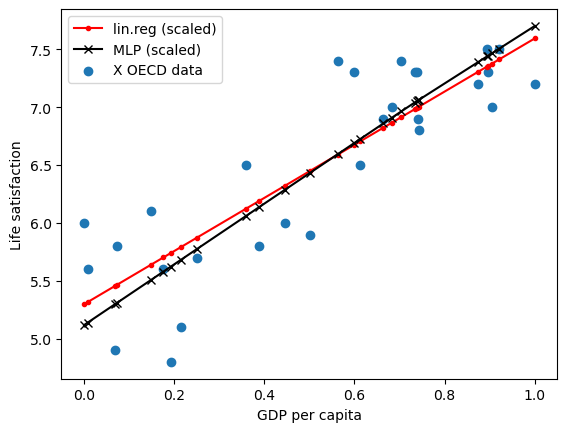

lin.reg (scaled).score(X, y)=0.73
    MLP (scaled).score(X, y)=0.72


In [ ]:
# LAV OM
from sklearn.preprocessing import MinMaxScaler

# Step 1: Apply Min-Max Scaling to X
scaler = MinMaxScaler(feature_range=(0,1)) # Skal laves om så den ikke bruger MinMaxScaler, men scales manuelt
X_scaled = scaler.fit_transform(X)  # Scale X to [0,1]

# Step 2: Create new MLP and Linear Regression models
mlp_scaled = MLPRegressor(hidden_layer_sizes=(10,),
                           solver='adam',
                           activation='relu',
                           tol=1E-5,
                           max_iter=100000,
                           verbose=False)

linreg_scaled = LinearRegression()

# Step 3: Train 
mlp_scaled.fit(X_scaled, y)
linreg_scaled.fit(X_scaled, y)

# Step 4: Compare
print("\nComparing models before and after scaling:")
PlotModels(linreg_scaled, mlp_scaled, X_scaled, y, "lin.reg (scaled)", "MLP (scaled)")


### Qb) Scikit-learn Pipelines

Now, rescale again, but use the `sklearn.preprocessing.MinMaxScaler`.

When this works put both the MLP and the scaler into a composite construction via `sklearn.pipeline.Pipeline`. This composite is just a new Scikit-learn estimator, and can be used just like any other `fit-predict` models, try it, and document it for the journal.

(You could reuse the `PlotModels()` function by also retraining the linear regressor on the scaled data, or just write your own plot code.)

MLP Pipeline R² Score: 0.7216
Linear Regression Pipeline R² Score: 0.7344


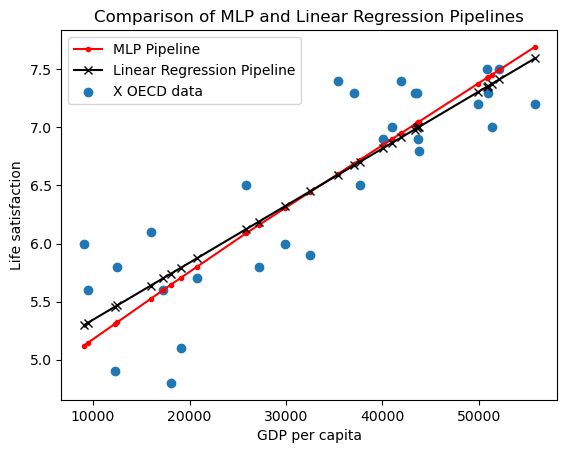

In [5]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt

# Step 1: Define the pipeline
mlp_pipeline = Pipeline([
    ('scaler', MinMaxScaler(feature_range=(0,1))),
    ('mlp', MLPRegressor(hidden_layer_sizes=(10,), solver='adam', activation='relu',
                         tol=1E-5, max_iter=100000, verbose=False))
])

# Step 2: Train the MLP pipeline
mlp_pipeline.fit(X, y)

# Step 3: Train a linear regressor with scaling for comparison
linreg_pipeline = Pipeline([
    ('scaler', MinMaxScaler(feature_range=(0,1))),
    ('linreg', LinearRegression())
])
linreg_pipeline.fit(X, y)

# Step 4: Make predictions
y_pred_mlp = mlp_pipeline.predict(X)
y_pred_linreg = linreg_pipeline.predict(X)

# Step 5: Calculate R² scores
r2_mlp = r2_score(y, y_pred_mlp)
r2_linreg = r2_score(y, y_pred_linreg)

print(f"MLP Pipeline R² Score: {r2_mlp:.4f}")
print(f"Linear Regression Pipeline R² Score: {r2_linreg:.4f}")

# Step 6: Plot the models
plt.plot(X, y_pred_mlp, "r.-", label="MLP Pipeline")
plt.plot(X, y_pred_linreg, "kx-", label="Linear Regression Pipeline")
plt.scatter(X, y, label="X OECD data")
plt.xlabel("GDP per capita")
plt.ylabel("Life satisfaction")
plt.legend()
plt.title("Comparison of MLP and Linear Regression Pipelines")
plt.show()


### Qc) Outliers and the Min-max Scaler vs. the Standard Scaler

Explain the fundamental problem with a min-max scaler and outliers. 

Will a `sklearn.preprocessing.StandardScaler` do better here, in the case of abnormal feature values/outliers?

In [ ]:
# TODO: research the problem here..
assert False, "TODO: investigate outlier problems and try a StandardScaler.."

### Qd) Modify the MLP Hyperparameters

Finally, try out some of the hyperparameters associated with the MLP.

Specifically, test how few neurons the MLP can do with---still producing a sensible output, i.e. high $R^2$. 

Also try-out some other activation functions, ala sigmoid, and solvers, like `sgd`.

Notice, that the Scikit-learn MLP does not have as many adjustable parameters, as a Keras MLP, for example, the Scikit-learn MLP misses neurons initialization parameters (pp.333-334 2nd./pp.358-359 3rd. [HOML]) and the ELU activation function (p.336 2nd./ p.363 3rd. [HOML]).

[OPTIONAL 1]: use a Keras MLP regressor instead of the Scikit-learn MLP (You need to install the  Keras if its not installed as default).

[OPTIONAL 2]: try out the `early_stopping` hyperparameter on the `MLPRegressor`. 

[OPTIONAL 3]: try putting all score-calculations into K-fold cross-validation  methods readily available in Scikit-learn using

* `sklearn.model_selection.cross_val_predict`
* `sklearn.model_selection.cross_val_score` 

or similar (this is, in theory, the correct method, but can be hard to use due to the  extremely small number of data points, `n=29`).

In [ ]:
# TODO: add your code here..
assert False, "TODO: test out various hyperparameters for the MLP.."

REVISIONS||
:-|:-|
2020-10-15| CEF, initial. 
2020-10-21| CEF, added Standard Scaler Q.
2020-11-17| CEF, removed orhpant text in Qa (moded to Qc).
2021-02-10| CEF, updated for ITMAL F21.
2021-11-08| CEF, updated print info.
2021-02-10| CEF, updated for SWMAL F22.
2023-02-19| CEF, updated for SWMAL F23, adjuste page numbers for 3rd.ed.
2023-02-21| CEF, added types, rewrote CalcPredAndScore and added isNumpyData.
2024-09-11| CEF, updated page refefences.